<a href="https://colab.research.google.com/github/Chada2307/MoodTracker/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

##drive.mount('/content')  # Podłączanie Dysku Google
data_path = "/content/drive/MyDrive/ColabNotebooks/Kolo/Projekt/archive.zip"  # Ścieżka do pliku


with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
os.listdir("/content/test")

['fear', 'neutral', 'surprise', 'angry', 'sad', 'happy', 'disgust']

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pth'):
        self.patience = patience  # ile epok czekamy zanim przerwiemy
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # im mniejszy loss, tym lepiej

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:


transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.0)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
data_dir = "/content"

batch_size=128
num_workers = 2

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform_train)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory = True)

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

print(os.cpu_count())

Train dataset size: 28709 images
Test dataset size: 7178 images
2


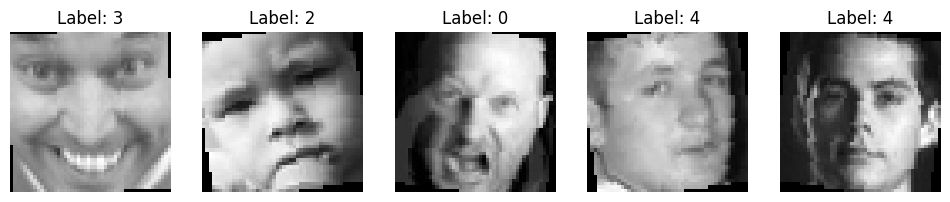

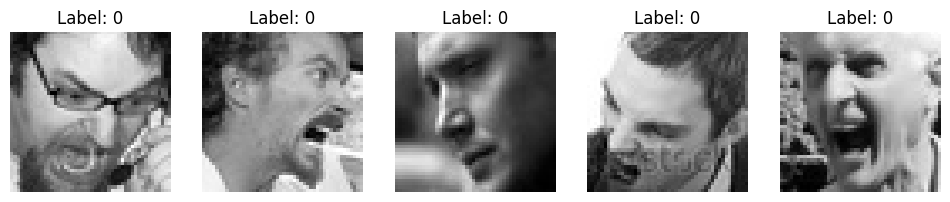

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

dataiter1 = iter(test_loader)
images, labels = next(dataiter1)

fig, axes = plt.subplots(1, 5, figsize = (12,4))

for i in range(5):
  img = images[i].squeeze().numpy()
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EmocjeCNN(nn.Module):
  def __init__(self):
    super(EmocjeCNN,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(128 * 6 * 6 , 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 7)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 128 * 6 * 6)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [ ]:

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmocjeCNN().to(device)

kryteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

print("GPU dostępne:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak GPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



GPU dostępne: True
Nazwa GPU: Tesla T4


Epoch 1/5, Loss: 1.800065321486883
Epoch 2/5, Loss: 1.6552521019576651
Epoch 3/5, Loss: 1.5390821666122811
Epoch 4/5, Loss: 1.4416565518071232
Epoch 5/5, Loss: 1.3691253117835336


In [ ]:
checkpoint = torch.load('/content/model_checkpoint.pth')

# Załadowanie stanu modelu i optymalizatora
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Kontynuowanie treningu
start_epoch = checkpoint['epoch'] + 1
train_loss = checkpoint['train_loss']
test_loss = checkpoint['test_loss']
early_stopping_counter = 0
print(f"Model loaded")

Model loaded


In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=True, path='best_model.pth')

In [ ]:
train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = kryteria(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  # sumujemy przez całą epokę

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = running_loss / total

    # Walidacja (z test_loss):
    model.eval()
    correct_test = 0
    total_test = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = kryteria(outputs, labels)

            test_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_loss = test_running_loss / total_test

    # Zbieranie danych do wykresu
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Accuracy: {train_acc:.2f}%, Loss: {train_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%, Loss: {test_loss:.4f}")
    print("-" * 40)


    ##early_stopping(test_loss, model)

   ## if early_stopping.early_stop:
     ##   print("Wczesne zatrzymanie treningu! ⛔")
     ##   break




    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'test_loss': test_loss,
    }, 'model_checkpoint.pth')

Epoch [1/50]
Train Accuracy: 80.65%, Loss: 0.5205
Test Accuracy: 64.53%, Loss: 1.1652
----------------------------------------
Epoch [2/50]
Train Accuracy: 81.36%, Loss: 0.5088
Test Accuracy: 64.84%, Loss: 1.2093
----------------------------------------
Epoch [3/50]
Train Accuracy: 81.65%, Loss: 0.4942
Test Accuracy: 65.17%, Loss: 1.2152
----------------------------------------
Epoch [4/50]
Train Accuracy: 81.97%, Loss: 0.4909
Test Accuracy: 64.71%, Loss: 1.2288
----------------------------------------
Epoch [5/50]
Train Accuracy: 81.95%, Loss: 0.4853
Test Accuracy: 64.81%, Loss: 1.2475
----------------------------------------
Epoch [6/50]
Train Accuracy: 82.23%, Loss: 0.4805
Test Accuracy: 64.61%, Loss: 1.2436
----------------------------------------
Epoch [7/50]
Train Accuracy: 82.23%, Loss: 0.4822
Test Accuracy: 64.70%, Loss: 1.2398
----------------------------------------
Epoch [8/50]
Train Accuracy: 82.66%, Loss: 0.4732
Test Accuracy: 64.43%, Loss: 1.2583
-------------------------

NameError: name 'val_accuracy' is not defined

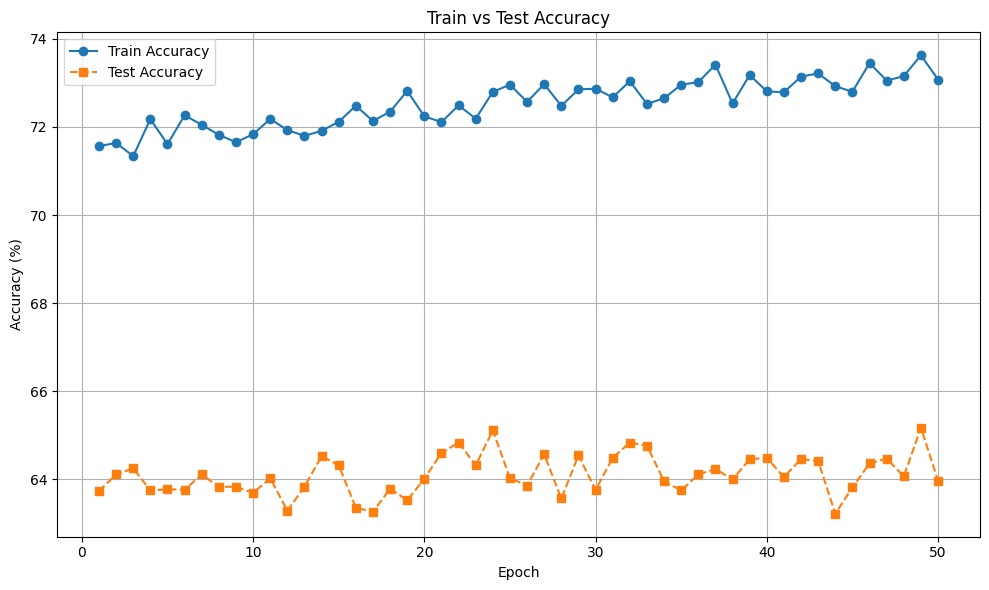

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 's--', label='Test Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_accuracy(train_accuracies, test_accuracies)